# Exploring Pyro's Probabilistic Programming for Logistic Regression

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import bernoulli, lognorm, norm, multivariate_normal
from scipy.special import logit, expit

import torch
import torch.nn as nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.optim import Adam

pyro.set_rng_seed(1)
pyro.enable_validation(True)
torch.set_default_dtype(torch.double) # this was necessary on the CPU

logDet = lambda x:np.linalg.slogdet(x)[1]
plogis = lambda x: (1+ np.tanh(x/2))/2

In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)

## Step 1: Generate random data
First, we try to simulate the observations based on simulated parameters

In [3]:
def generate_data_single_variable_norm(intercept=-1,
                                       slope=1,
                                       variants=5,
                                       sample=10000):
    
    
    x_simulated = np.random.choice(variants,sample)/(variants-1)
#     noise = norm.rvs(loc=0,scale=noise_std,size=sample)
    y_simulated = bernoulli.rvs(expit(intercept + slope*x_simulated))
    
    return pd.DataFrame(np.stack((x_simulated,y_simulated),axis=-1),
                        columns=["variants","success"])

def generate_data_two_variable_norm(mu,sigma,sample):
    return df_simulated

def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values.squeeze())
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [4]:
pd_sample = generate_data_single_variable_norm(intercept = -3,slope=0.1,sample=10000)

pd_sample

,variants,success
0,0.75,0.0
1,1.00,0.0
2,0.00,0.0
3,0.25,0.0
4,0.75,0.0
...,...,...
9995,0.00,0.0
9996,0.25,0.0
9997,0.00,0.0
9998,0.50,0.0


In [5]:
pd_summary = pd_sample.groupby("variants").agg(success = ("success",np.sum),trials=("success",np.size))
pd_summary["success_rate"] = pd_summary["success"]/pd_summary["trials"]
pd_summary

,success,trials,success_rate
variants,,,
0.00,92.0,2024.0,0.045455
0.25,88.0,1933.0,0.045525
0.50,90.0,2028.0,0.044379
0.75,105.0,2013.0,0.052161
1.00,89.0,2002.0,0.044456


## Step 2: Define Model

In [6]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()
        
        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 10.0 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale = 10.0 * torch.ones(1)
        
        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight", dist.Normal(self.alpha_h_loc, self.alpha_h_scale, validate_args=True).independent(1)
        )
        b = pyro.sample(
            "bias", dist.Normal(self.beta_h_loc, self.beta_h_scale, validate_args=True).independent(1)
        )

        with pyro.iarange("data", x.size(0)):
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()
            
            pyro.sample(
                "obs", 
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze()
            )
            
    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)

        pyro.sample(
            "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )

### Porting CAVI routine from R


In [7]:
def logRegressionCAVI(design_mat,obs_mat,prior=None,tol=1e-16, maxiter=5000):
    num_data, design_vars = design_mat.shape
    
    if prior is None:
        prior = {"mu": np.zeros(design_vars),
                "sigma": 10*np.eye(design_vars)} 
        
    inv_sigma = np.linalg.inv(prior["sigma"])
    mu = prior["mu"]
    inv_sigma_mu = np.matmul(inv_sigma,mu).squeeze()
    inv_sigma_logdet=logDet(inv_sigma)
    omega = 0.25*np.ones((num_data,design_vars)) # initial guess of omega
    
    lower_bound = []

    for i in range(maxiter):
        inv_sigma_vb = np.matmul(np.multiply(omega,design_mat).T,design_mat) + inv_sigma
        sigma_vb = np.linalg.inv(inv_sigma_vb)
        mu_vb = np.matmul(sigma_vb,(np.matmul(design_mat.T,obs_mat - 0.5) + inv_sigma_mu))
        eta = np.matmul(design_mat,mu_vb)
        xi = np.sqrt(np.power(eta,2)+np.sum(np.multiply(np.matmul(design_mat,sigma_vb),design_mat),axis=1))
        omega = np.tile(np.divide(np.tanh(xi/2),2*xi),(design_vars,1)).T


        lower_bound += [(0.5*design_vars + 0.5*logDet(sigma_vb) + 0.5*inv_sigma_logdet - 
                      0.5*np.matmul(np.matmul((mu_vb-mu).T,inv_sigma),(mu_vb-mu)) + 
                      np.sum(np.multiply(obs_mat - 0.5,eta) + np.log(plogis(xi)) - 0.5*xi) - 
                      0.5*np.sum(np.diag(np.matmul(inv_sigma,sigma_vb))))]

        if i > 0:
            if abs(lower_bound[i] - lower_bound[i-1]) < tol:
                return {"mu": mu_vb,
                          "sigma": sigma_vb,
                          "convergence": {"iteration": np.arange(i),"lower_bound":np.array(lower_bound)},
                          "xi": xi}

            
    print("Algorithm fails to reach convergence at maximum iteration")
    return None

In [8]:
# pd_sample["variants"].values
# np.ones(pd_sample["variants"].values.shape[0])
maxiter = 5000
tol =1e-10
sites = ["bias","weight"]
obs_mat = pd_sample["success"].values
design_mat = np.column_stack((np.ones(pd_sample["variants"].values.shape),
                                 pd_sample["variants"].values))

# np.matmul(0.25*design_matrix.T,design_matrix)


# num_data, design_vars = design_mat.shape
# prior = {"mu": np.zeros(2),"sigma": 10*np.eye(2)}
# inv_sigma = np.linalg.inv(prior["sigma"])
# mu = prior["mu"]

# inv_sigma_mu = np.matmul(inv_sigma,mu).squeeze()
# inv_sigma_logdet=logDet(inv_sigma)
# omega = 0.25*np.ones((num_data,design_vars))
# lower_bound = []


# for i in range(maxiter):
#     inv_sigma_vb = np.matmul(np.multiply(omega,design_mat).T,design_mat) + inv_sigma
#     sigma_vb = np.linalg.inv(inv_sigma_vb)
#     mu_vb = np.matmul(sigma_vb,(np.matmul(design_mat.T,obs_mat - 0.5) + inv_sigma_mu))
#     eta = np.matmul(design_mat,mu_vb)
#     xi = np.sqrt(np.power(eta,2)+np.sum(np.multiply(np.matmul(design_mat,sigma_vb),design_mat),axis=1))
#     omega = np.divide(np.tanh(xi/2),2*xi)

#     lower_bound += [(0.5*design_vars + 0.5*logDet(sigma_vb) + 0.5*inv_sigma_logdet - 
#                   0.5*np.matmul(np.matmul((mu_vb-mu).T,inv_sigma),(mu_vb-mu)) + 
#                   np.sum(np.multiply(obs_mat - 0.5,eta) + np.log(plogis(xi)) - 0.5*xi) - 
#                   0.5*np.sum(np.diag(np.matmul(inv_sigma,sigma_vb))))]

#     if i > 0:
#         if abs(lower_bound[i] - lower_bound[i-1]) < tol:
#             return {"mu": mu_vb,
#                       "sigma": sigma_vb,
#                       "convergence": {"iteration": np.arange(i),"lower_bound":np.array(lower_bound)},
#                       "xi": xi}
     
# print("Algorithm fails to reach convergence at maximum iteration")
# return None

start_time = time.time()
cavi = logRegressionCAVI(design_mat,obs_mat)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08897089958190918 seconds ---


In [29]:

draws = np.random.multivariate_normal(mean=cavi["mu"],cov=cavi["sigma"],size=2000)
cavi_samples = {sites[i]: draws[:,i] for i in range(len(sites))}

for site, values in summary(cavi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: bias
       mean       std        5%       25%       50%       75%       95%
0 -3.044155  0.043794 -3.115067 -3.073678 -3.043528 -3.014674 -2.974292 

Site: weight
       mean      std        5%       25%       50%       75%       95%
0  0.041561  0.07237 -0.075784 -0.008428  0.041048  0.091723  0.158751 



In [30]:
print(sum(cavi_samples["weight"] > 0)/len(cavi_samples["weight"]))

0.716


In [26]:
optim = Adam({"lr": 0.05})

log_reg_single = LogRegressionModel(p=1)

svi = SVI(log_reg_single.model,log_reg_single.guide,optim,loss = Trace_ELBO(), num_samples=1000)

y = pd_sample["success"].values
X = pd_sample["variants"].values

lr_dataset = torch.tensor(pd_sample.values)

prev_elbo = 0
pyro.clear_param_store()

start_time = time.time()
num_iters = 2000
for i in range(num_iters):
    elbo = svi.step(lr_dataset[:,:-1],lr_dataset[:,-1])
#     elbo_diff = abs(prev_elbo - elbo)
#     prev_elbo = elbo
#     if i % 10 == 0:
#         print("Elbo loss: {}, convergence: {}".format(elbo,elbo_diff))
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.614118814468384 seconds ---


In [27]:
svi_diagnorm_posterior = svi.run(lr_dataset[:,:-1],lr_dataset[:,-1])

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}

for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: bias
       mean       std        5%       25%       50%       75%       95%
0 -3.037145  0.075751 -3.163044 -3.088406 -3.034161 -2.986645 -2.914699 

Site: weight
       mean       std       5%       25%       50%       75%       95%
0  0.039225  0.110291 -0.13846 -0.034694  0.039765  0.114941  0.222275 



In [28]:
print(sum(svi_samples["weight"].squeeze() > 0)/len(svi_samples["weight"].squeeze()))

0.641


In [13]:
pyro.clear_param_store()
nuts_kernel = NUTS(log_reg_single.model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(lr_dataset[:,:-1],lr_dataset[:,-1])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [00:09<00:00, 125.53it/s, step size=5.22e-01, acc. prob=0.923]


In [14]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: weight
       mean       std        5%       25%      50%       75%       95%
0  0.049014  0.135857 -0.156989 -0.053842  0.04011  0.136805  0.279136 

Site: bias
       mean       std       5%       25%       50%       75%       95%
0 -3.049369  0.087275 -3.19885 -3.108568 -3.043485 -2.985442 -2.920595 



In [31]:
print(sum(hmc_samples["weight"].squeeze() > 0)/len(hmc_samples["weight"].squeeze()))

0.622


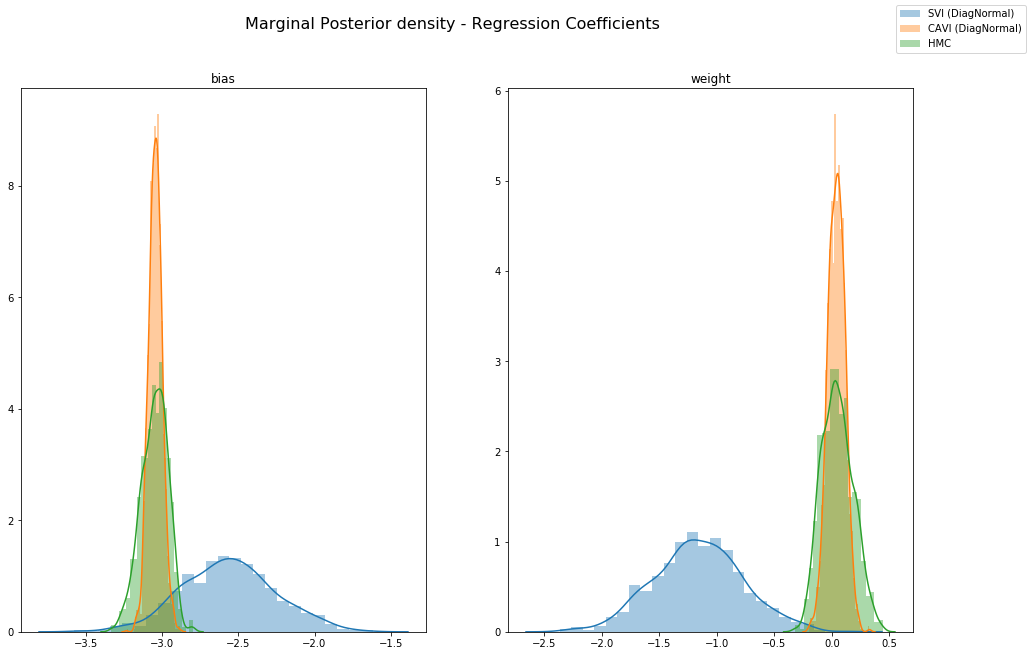

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(cavi_samples[site], ax=ax, label="CAVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [ ]:
# from pyro.contrib.autoguide.initialization import init_to_mean
mvn_guide = AutoMultivariateNormal(log_reg_single.model)

svi_mvn = SVI(log_reg_single.model,mvn_guide,optim,loss = Trace_ELBO(), num_samples=1000)

lr_dataset = torch.tensor(pd_sample.values)

prev_elbo = 0
pyro.clear_param_store()
num_iters = 10000
for i in range(num_iters):
    elbo = svi_mvn.step(lr_dataset[:,:-1],lr_dataset[:,-1])
#     elbo_diff = abs(prev_elbo - elbo)
#     prev_elbo = elbo
#     if i % 50 == 0:
#         print("Elbo loss: {}, convergence: {}".format(elbo,elbo_diff))

In [ ]:
svi_mvn_posterior = svi_mvn.run(lr_dataset[:,:-1],lr_dataset[:,-1])
svi_mvn_samples = {site: EmpiricalMarginal(svi_mvn_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (MVN)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');